In [86]:
import csv
import pandas as pd

df = pd.read_csv('archive/SPAM text message 20170820 - Data.csv')


In [87]:
df.head

<bound method NDFrame.head of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [88]:
df = df[['Category', 'Message']]

In [89]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [90]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

5572

Clean indexing: If the original CSV file had non-sequential or missing row numbers, this ensures a clean, continuous index

In [92]:
df.index = range(5572)

calculating total word count in dataset

In [93]:
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

In [94]:
count = df['Category'].value_counts()
count.index

Index(['ham', 'spam'], dtype='object', name='Category')

In [95]:
count.values

array([4825,  747], dtype=int64)

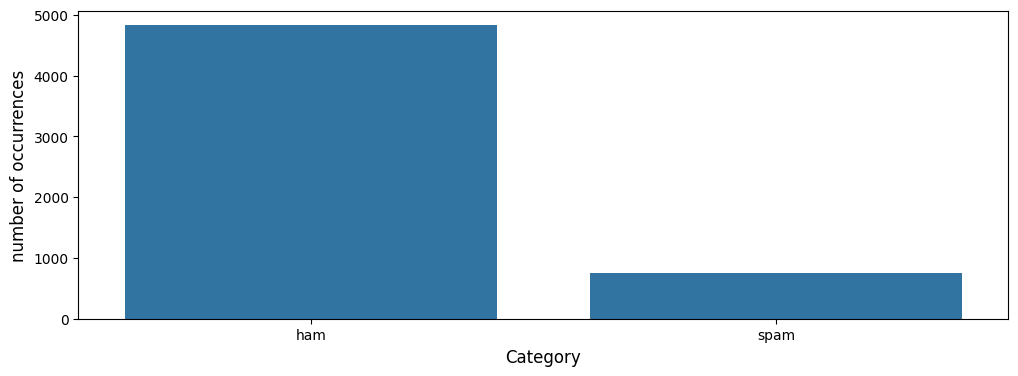

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,4))
sns.barplot(count)

plt.ylabel('number of occurrences', fontsize=12)
plt.xlabel('Category',fontsize=12)
plt.show()



In [97]:
example = df['Message'].values[0]
example

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [98]:
len(example)

111

In [99]:
def print_message(index):
    example = df[df.index == index][['Message','Category']].values[0]
    
    if len(example)>0:
        print('category : ', example[1])
        print(' message : ', example[0])

print_message(16)

category :  ham
 message :  Oh k...i'm watching here:)


In [100]:
from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'http\S+', r'<URL' ,text)
    text = text.lower()
    
    return text

df['Message'] = df["Message"].apply(cleanText)

In [101]:
max_features = 500000

MAX_SEQ_LEN = 50



In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [103]:
tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!@#$%^&*()_+{;}|:"<>?', lower=True)
tokenizer.fit_on_texts(df['Message'].values)

Example:
If your dataset is:

["I love cats", "I love dogs"]


After fitting:

word_index = {"i": 1, "love": 2, "cats": 3, "dogs": 4}

In [104]:
X = tokenizer.texts_to_sequences(df['Message'].values)


This converts each sentence into a list of integers.
Example:

"I love cats" → [1, 2, 3]
"I love dogs" → [1, 2, 4]

In [142]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_label = label_encoder.fit_transform(df['Category'])

y = to_categorical(integer_label)
y

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [106]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen = MAX_SEQ_LEN)

In [107]:
X

array([[    0,     0,     0, ...,    53,  5159,   850],
       [    0,     0,     0, ...,   415,     6,  3320],
       [    0,     0,     0, ...,   619,   581,  3321],
       ...,
       [    0,     0,     0, ..., 12036,   231, 12037],
       [    0,     0,     0, ...,   202,    11,    50],
       [    0,     0,     0, ...,     2,    59,   281]])

In [108]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.01, random_state=41)



In [109]:
print("tensor data shape", X.shape)

tensor data shape (5572, 50)


In [110]:
len(tokenizer.word_index)

12039

In [111]:
vocab_size = len(tokenizer.word_index) +1 

creating the lstm model

In [112]:
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential


model = Sequential()

model.add(Embedding(input_dim=vocab_size, 
                    output_dim=128, 
                    input_length=MAX_SEQ_LEN,
                    name="embedding"))

C:\Users\Bachu Sai Raj\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [113]:
model.add(LSTM(64,return_sequences=True))
model.add(Dense(2, activation="softmax"))

model.summary()

#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [140]:
model.fit(X_train,y_train, epochs=5, batch_size=32,validation_data=(X_test,y_test))

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 2), output.shape=(None, 50, 2)